In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import matplotlib.patches as mpatches
from scipy import stats

In [3]:
sns.set_style("darkgrid")

ID = "0704"
figure_path = "figs" + os.sep + ID + os.sep

if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
figure_path = figure_path + "expDetermineProbCompare_"

# figure settings
sns.set_style("darkgrid")

INIT_COL = sns.color_palette('colorblind')[0]
RESP_COL = sns.color_palette('colorblind')[1]

meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(facecolor=INIT_COL, color="black", alpha=0.5)

TICK_SIZE = 20
VALUE_SIZE = 14
LABEL_SIZE = 26
FIG_SIZE = (12,7)

In [4]:
directory = "../results/results_" + ID + "_determine_prob_compare"
idx = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue
    newdata = pd.read_csv(f, index_col = None)
    if (idx == 0):
        data = newdata
    else:
        data = pd.concat([data, newdata], ignore_index = True)
    idx += 1
    
print("Number of observations: " + str(len(data.index)))
print("Number of observations per group: " + str(len(data.index) / 24))

Number of observations: 24000
Number of observations per group: 1000.0


In [5]:
df = copy.deepcopy(data[["init_tom", "resp_tom", "init_canLie", "resp_canLie", "init_numberOfMessagesSent",
           "resp_numberOfMessagesSent", "init_numberOfTimesLied", "resp_numberOfTimesLied", "nr_offers"]])

In [6]:
df["init_nr_offers"] = df.apply(lambda x: x["nr_offers"] / 2 if (x["nr_offers"] % 2 == 0) else ((x["nr_offers"] + 1) / 2), axis=1)
df["resp_nr_offers"] = df.apply(lambda x: x["nr_offers"] / 2 if (x["nr_offers"] % 2 == 0) else ((x["nr_offers"] - 1) / 2), axis=1)

In [7]:
df_results = pd.DataFrame(columns=["name", "count", "nr_offers", "nr_of_messages", "nr_of_times_lied"])
df_results.loc[0] = ["two_canLie", 0, 0, 0, 0]
df_results.loc[1] = ["two_cannotLie", 0, 0, 0, 0]
df_results.loc[2] = ["one_canLie", 0, 0, 0, 0]
df_results.loc[3] = ["one_cannotLie", 0, 0, 0, 0]

df_results = df_results.set_index("name", drop=False)
for name, tom, canLie in [("one_cannotLie", 1, False), ("one_canLie", 1, True), ("two_cannotLie", 2, False), ("two_canLie", 2, True)]:
    sub_init_df = df[(df["init_tom"] == tom) & (df["init_canLie"] == canLie)]
    sub_resp_df = df[(df["resp_tom"] == tom) & (df["resp_canLie"] == canLie)]
       
    df_results.loc[name, "nr_offers"] += sum(sub_init_df["init_nr_offers"]) + sum(sub_resp_df["resp_nr_offers"])
    df_results.loc[name, "nr_of_messages"] += sum(sub_init_df["init_numberOfMessagesSent"]) + sum(sub_resp_df["resp_numberOfMessagesSent"])
    df_results.loc[name, "nr_of_times_lied"] += sum(sub_init_df["init_numberOfTimesLied"]) + sum(sub_resp_df["resp_numberOfTimesLied"])
    df_results.loc[name, "count"] += len(sub_init_df) + len(sub_resp_df)

      
df_results.loc["total"] = ["total", sum(df_results["count"]), sum(df_results["nr_offers"]),
                           sum(df_results["nr_of_messages"]), sum(df_results["nr_of_times_lied"])]
df_results["percentage_send_messages"] = df_results.apply(lambda x: x["nr_of_messages"] / x["nr_offers"], axis=1)
df_results["nr_offers_without_message"] = df_results.apply(lambda x: x["nr_offers"] - x["nr_of_messages"], axis=1)
df_results

,name,count,nr_offers,nr_of_messages,nr_of_times_lied,percentage_send_messages,nr_offers_without_message
name,,,,,,,
two_canLie,two_canLie,10000,11800,4786,2764,0.405593,7014
two_cannotLie,two_cannotLie,10000,12013,4066,0,0.338467,7947
one_canLie,one_canLie,10000,13275,3641,3321,0.274275,9634
one_cannotLie,one_cannotLie,10000,12993,1329,0,0.102286,11664
total,total,40000,50081,13822,6085,0.275993,36259


[0.004520080994793632, 0.004317258746678215, 0.003872236424124385, 0.00265841077340217, 0.00199748656660933]


C:\Users\sverr\AppData\Local\Temp\ipykernel_22488\1196984909.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


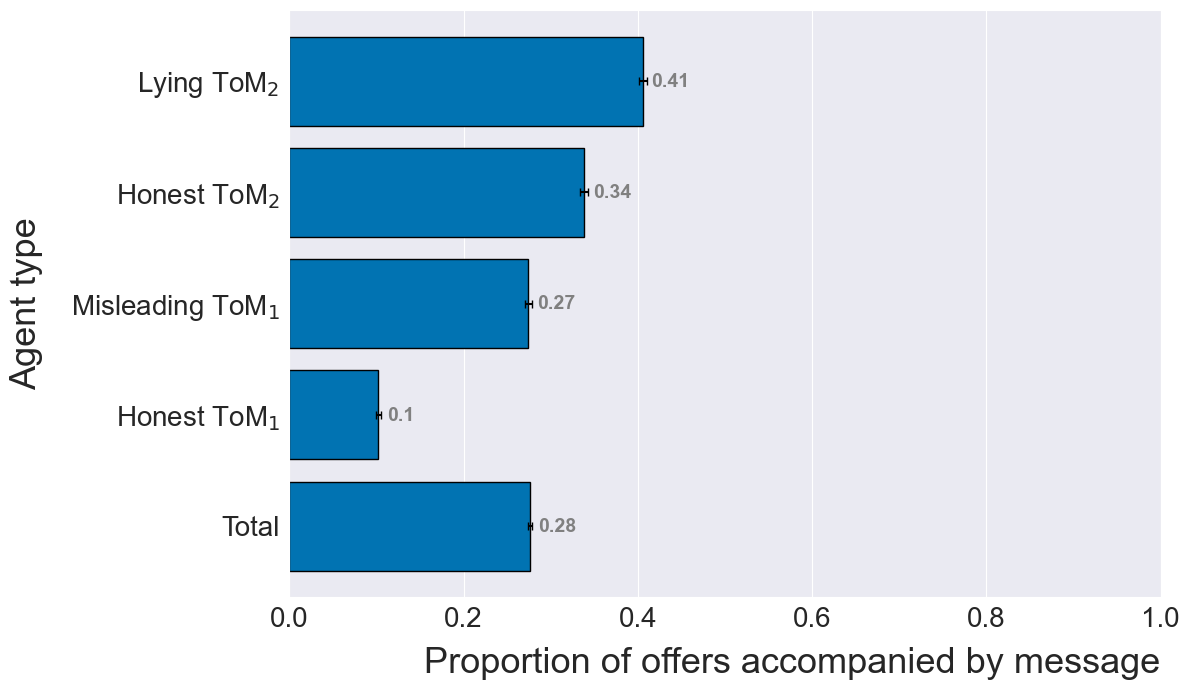

In [8]:
BIN_WIDTH = 0.4

def make_plot(data):
    fig, ax = plt.subplots(figsize = FIG_SIZE)
    
    names = data.index
    xerrs = [np.sqrt((p * (1 - p)) / n) for p, n in df_results[["percentage_send_messages", "nr_offers"]].values]
    print(xerrs)
    
    ax.barh(names, data["percentage_send_messages"], edgecolor="black", color=INIT_COL, xerr=xerrs, capsize=3)
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.45,
                str(round((i.get_width()), 2)),
                fontsize = VALUE_SIZE, fontweight ='bold',
                color ='grey')
    
    ax.set_xlim(right=1.0, left=0.0)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, which="both")
    
    y_labels = [r"Lying ToM$_2$", 
                r"Honest ToM$_2$",
                r"Misleading ToM$_1$", 
                r"Honest ToM$_1$",
                "Total"]
    
    
    ax.set_yticklabels(y_labels)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    ax.invert_yaxis()
    
    ax.set_ylabel("Agent type", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel("Proportion of offers accompanied by message", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    
    fig.tight_layout()
    
make_plot(df_results)
plt.savefig(figure_path + "barplot.pdf")

In [9]:
contingency_table = []
contingency_table.append(list(df_results.loc["one_cannotLie"].loc[["nr_of_messages", "nr_offers_without_message"]]))
contingency_table.append(list(df_results.loc["one_canLie"].loc[["nr_of_messages", "nr_offers_without_message"]]))
contingency_table.append(list(df_results.loc["two_cannotLie"].loc[["nr_of_messages", "nr_offers_without_message"]]))
contingency_table.append(list(df_results.loc["two_canLie"].loc[["nr_of_messages", "nr_offers_without_message"]]))
print(contingency_table)
print(np.sum(contingency_table))

stat, p, dof, expected = stats.chi2_contingency(contingency_table)
print(p)
print(stat)
print(dof)

[[1329, 11664], [3641, 9634], [4066, 7947], [4786, 7014]]
50081
0.0
3188.7260704730106
3


In [10]:
df_results_sep = pd.DataFrame(columns=["name", "count", "nr_offers", "nr_of_messages", "nr_of_times_lied"])
df_results_sep.loc[0] = ["init_two_canLie", 0, 0, 0, 0]
df_results_sep.loc[1] = ["resp_two_canLie", 0, 0, 0, 0]
df_results_sep.loc[2] = ["init_two_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[3] = ["resp_two_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[4] = ["init_one_canLie", 0, 0, 0, 0]
df_results_sep.loc[5] = ["resp_one_canLie", 0, 0, 0, 0]
df_results_sep.loc[6] = ["init_one_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[7] = ["resp_one_cannotLie", 0, 0, 0, 0]

df_results_sep = df_results_sep.set_index("name", drop=False)
for name, tom, canLie in [("init_one_cannotLie", 1, False), ("resp_one_cannotLie", 1, False),
                          ("init_one_canLie", 1, True), ("resp_one_canLie", 1, True),
                          ("init_two_cannotLie", 2, False), ("resp_two_cannotLie", 2, False),
                          ("init_two_canLie", 2, True), ("resp_two_canLie", 2, True)]:
    
    type_ir = "init" if ("init" in name) else "resp"
    sub_df = df[(df[f"{type_ir}_tom"] == tom) & (df[f"{type_ir}_canLie"] == canLie)]
    
    df_results_sep.loc[name, "nr_offers"] += sum(sub_df[f"{type_ir}_nr_offers"])
    df_results_sep.loc[name, "nr_of_messages"] += sum(sub_df[f"{type_ir}_numberOfMessagesSent"])
    df_results_sep.loc[name, "nr_of_times_lied"] += sum(sub_df[f"{type_ir}_numberOfTimesLied"])
    df_results_sep.loc[name, "count"] += len(sub_df)
      
df_results_temp = df_results_sep.loc[["init_two_canLie", "init_two_cannotLie", "init_one_canLie", "init_one_cannotLie"]]
df_results_sep.loc["total_init"] = ["total_init", sum(df_results_temp["count"]), sum(df_results_temp["nr_offers"]),
                           sum(df_results_temp["nr_of_messages"]), sum(df_results_temp["nr_of_times_lied"])]
df_results_temp = df_results_sep.loc[["resp_two_canLie", "resp_two_cannotLie", "resp_one_canLie", "resp_one_cannotLie"]]
df_results_sep.loc["total_resp"] = ["total_resp", sum(df_results_temp["count"]), sum(df_results_temp["nr_offers"]),
                           sum(df_results_temp["nr_of_messages"]), sum(df_results_temp["nr_of_times_lied"])]
df_results_sep["percentage_send_messages"] = df_results_sep.apply(lambda x: x["nr_of_messages"] / x["nr_offers"], axis=1)
df_results_sep

,name,count,nr_offers,nr_of_messages,nr_of_times_lied,percentage_send_messages
name,,,,,,
init_two_canLie,init_two_canLie,5000,7179,2586,1353,0.360217
resp_two_canLie,resp_two_canLie,5000,4621,2200,1411,0.476087
init_two_cannotLie,init_two_cannotLie,5000,7315,2164,0,0.295830
resp_two_cannotLie,resp_two_cannotLie,5000,4698,1902,0,0.404853
init_one_canLie,init_one_canLie,5000,7734,2237,2054,0.289242
resp_one_canLie,resp_one_canLie,5000,5541,1404,1267,0.253384
init_one_cannotLie,init_one_cannotLie,5000,7498,741,0,0.098826
resp_one_cannotLie,resp_one_cannotLie,5000,5495,588,0,0.107006
total_init,total_init,20000,29726,7728,3407,0.259974


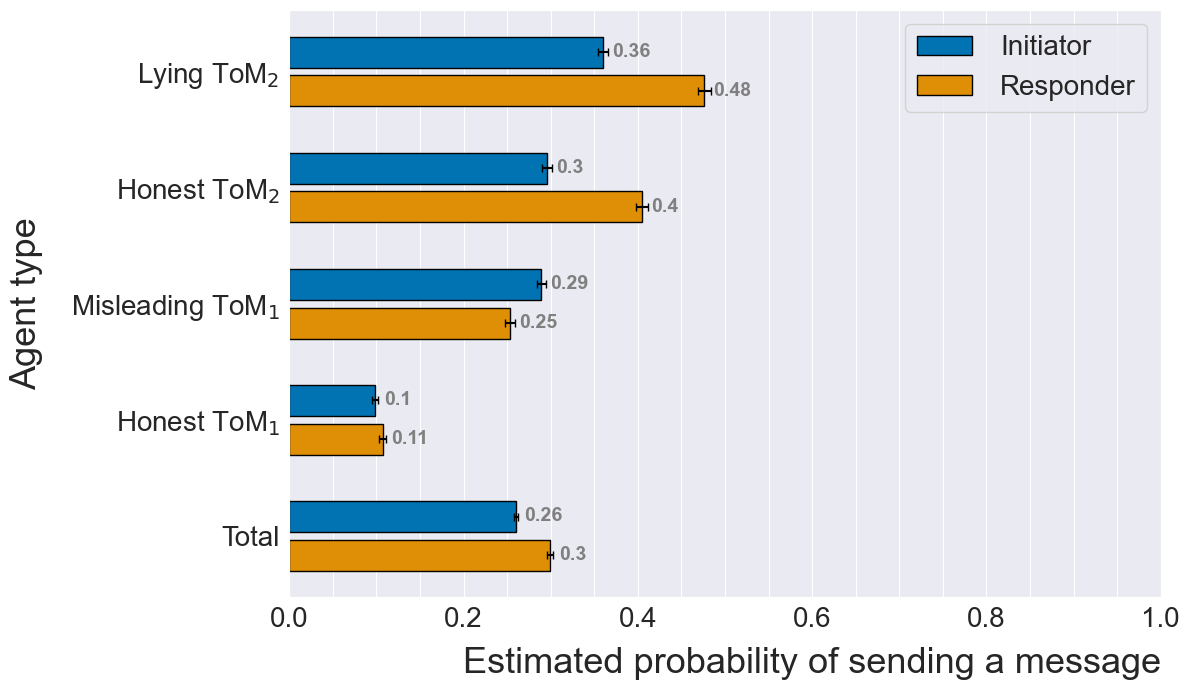

In [11]:
BIN_WIDTH = 0.4

def make_plot(data):
    fig, ax = plt.subplots(figsize = FIG_SIZE)
    
    pos = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]
    names = data.index
    
    for idx, name in enumerate(names):
        color = INIT_COL if (name.find("init") >= 0) else RESP_COL
        p = data["percentage_send_messages"].loc[name]
        xerr = np.sqrt((p * (1 - p)) / data["nr_offers"].loc[name])
        ax.barh(pos[idx], p, color=color, edgecolor="black", xerr=xerr, capsize=3)
        
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.52,
                str(round((i.get_width()), 2)),
                fontsize = VALUE_SIZE, fontweight ='bold',
                color ='grey')
    
    ax.set_xlim(right=1.0, left=0.0)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, which="both")
    
    y_ticks = []
    for i in range(0, len(pos),2):
        y_ticks.append((pos[i] + pos[i+1]) / 2)
    y_labels = [r"Lying ToM$_2$", 
                r"Honest ToM$_2$",
                r"Misleading ToM$_1$", 
                r"Honest ToM$_1$",
                "Total"]
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    ax.invert_yaxis()
    ax.legend((mpatches.Patch(facecolor=INIT_COL, edgecolor='black', label="Initiator"),
            mpatches.Patch(facecolor=RESP_COL, edgecolor='black', label="Responder")),
              ("Initiator" , "Responder"), fontsize=TICK_SIZE, ncol=1, fancybox=True, loc="upper right",
              handletextpad=1)
    
    ax.set_ylabel("Agent type", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel("Estimated probability of sending a message", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    
    fig.tight_layout()
    plt.minorticks_on()
    
    
make_plot(df_results_sep)
plt.savefig(figure_path + "barplot_separate.pdf")